# 1) Import Basic Libraries

In [162]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import fbprophet
import matplotlib.pyplot as plt
import warnings
import os
import logging
logging.getLogger('statsmodels').setLevel(logging.FATAL)
warnings.filterwarnings("ignore")

# 2) Import Dataset & Overview the Time Series to be Forecasted

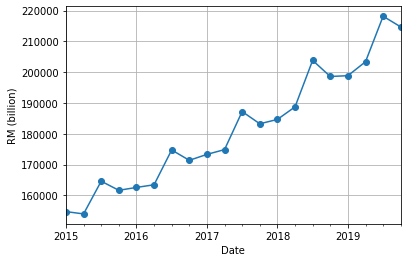

In [163]:
xl = pd.ExcelFile('MoF_PCON_Variables.xlsx')

# Load the Excel File
df_ori = xl.parse('Variables', parse_dates=[0])
df_ori = df_ori.set_index('Date')
df_ori['PCON'].plot(marker = 'o')
plt.ylabel('RM (billion)')
plt.grid()
y = df_ori['PCON']
d=0

# 3) Determine the order of differencing (d) for the target variable

ADF Statistic: -3.022203
p-value: 0.032872

After some looping, this time series dataset has become stationary. Hence, it does not need to undergo differencing anymore.

As of now, d =  2


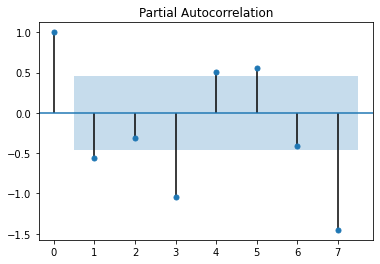

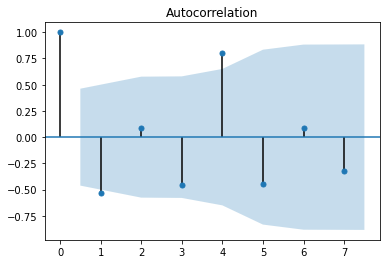

In [166]:
from statsmodels.tsa.stattools import adfuller
from numpy import log

result = adfuller(y.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

if result[1] < 0.05:
    if d == 0:
        print('\nThis time series dataset is stationary. Hence, it does not need to undergo differencing and d = 0\n')
    
    elif d != 0:
        print('\nAfter some looping, this time series dataset has become stationary. Hence, it does not need to undergo differencing anymore.\n')
        print('As of now, d = ',d)
    
else:
    print('\nThis time series dataset is not stationary. Hence, it must undergo differencing and d != 0\n')
    y = y.diff().dropna()
    d+=1
    
import statsmodels.api as statsmodels
#import statsmodels as statsmodels

plot_pacf = statsmodels.graphics.tsa.plot_pacf(y.values.squeeze(), lags = 7)
plot_acf = statsmodels.graphics.tsa.plot_acf(y.values.squeeze(), lags = 7)

# 4) Determine the order of differencing (d) for the all variables

In [149]:
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as statsmodels
from numpy import log
rows = []
for i in range(len(df_ori.columns)):
    #print('\n--------------------------------')
    y = df_ori.iloc[:,i]
    d=0        
    result = adfuller(y.values)
    while result[1] > 0.05:
        #print('%s' %df_ori.iloc[:,i].name, 'is not stationary. Hence, it must undergo differencing. Looping!')
        y = y.diff().dropna()
        result = adfuller(y.values)
        d+=1
    
    #print('ADF Statistic: %f' % result[0])
    #print('p-value: %f' % result[1])
    
    if result[1] < 0.05:
        #print('\n%s' %df_ori.iloc[:,i].name, 'is stationary. Hence, it does not need to undergo differencing')
        #print('As of now, d = ',d)
        #print('--------------------------------\n')
        row = list([df_ori.iloc[:,i].name, d, result[1]])
        rows.append(row)
        #plot_pacf = statsmodels.graphics.tsa.plot_pacf(y.values.squeeze(), lags = 7)
        #plot_acf = statsmodels.graphics.tsa.plot_acf(y.values.squeeze(), lags = 7)
MoF_d_values = pd.DataFrame(rows, columns = ['Attributes', 'd', 'p-value'])
MoF_d_values 

,Attributes,d,p-value
0,FS,1,1.401415e-04
1,ICG,1,9.252512e-09
2,TSP,0,1.455743e-02
3,SOM,1,2.653202e-06
4,SOPC,2,7.875074e-03
5,CC,1,5.019448e-03
6,CCD,1,2.606091e-07
7,LOWT,1,9.036987e-05
8,CCS,3,2.892864e-02
9,LDH,3,1.152065e-05


- Since we are interested in PCON as the target variable, so we determined that the d = 2 for PCON

# 5) Forecasting using multiple models

In [204]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.api import VAR

# Vector Autoregression
y = df_ori.copy()                                           # Copy original dataframe
y = y[['SOPC', 'EMP', 'PCON']]                              # Select all variables that has d = 2 (same as PCON)
VAR = VAR(y).fit(2)                                         # Train the model
lag_order = VAR.k_ar                                        # Get the lag order
forecast_input = y.values[-lag_order-1:-1]                  # Input data for forecasting
fc = VAR.forecast(y=forecast_input, steps=5)                # Forecasting
df_forecast = pd.DataFrame(fc, columns=y.columns)
VAR_forefast = df_forecast[['PCON']].rename({'PCON':'Vector Autoregression'}, axis = 1)
df_date = pd.DataFrame(pd.date_range(start="2019-12-31",end="2020-12-31",freq='Q'), columns=['Date'])
VAR_forefast = pd.concat([df_date, VAR_forefast], axis = 1)

# Autoregressive Integrated Moving Average (ARIMA)
ARIMA = ARIMA(endog=df_ori['PCON'], order=(2,2,2)).fit()
ARIMA_predict = ARIMA.predict(start = 19, end = 23)
ARIMA_forecast = ARIMA_predict.to_frame(name='ARIMA')

# Autoregression
AR = AR(df_ori['PCON'], freq='Q').fit()
AR_predict = AR.predict(start = 19, end = 23)
AR_forecast = AR_predict.to_frame(name='Autoregression')

# Exponential Smoothing
ES = ExponentialSmoothing(endog=df_ori['PCON'],trend='add', freq='Q',seasonal='add', seasonal_periods=4).fit()
ES_predict = ES.predict(start = 19, end = 23)
ES_forecast = ES_predict.to_frame(name='Exponential Smoothing')

# 6) Combine All Tables and Visualise the Forecasts

Text(0.5, 1.0, "\nForecasting of Malaysia's Private Consumption\n")

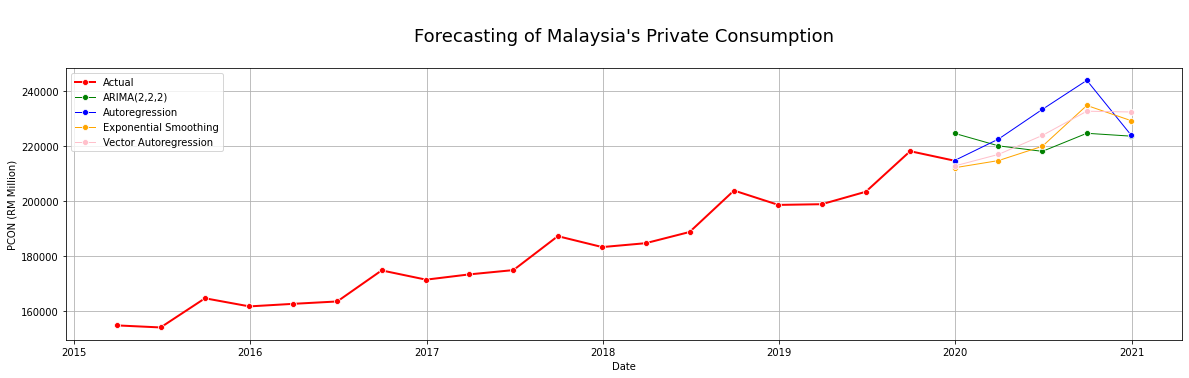

In [205]:
import time
from datetime import datetime
#df_date = pd.DataFrame(pd.date_range(start="2015-03-31",end="2020-12-31",freq='Q'), columns=['Date'])
df_final = pd.concat([df_ori['PCON'], ARIMA_forecast, AR_forecast, ES_forecast], axis = 1)
df_final = df_final.reset_index().rename({'index':'Date'}, axis = 1)

import seaborn as sns
plt.figure(figsize=(20,5))
sns.lineplot(x="Date", y="PCON",data=df_final, lw=2, color='red', marker ='o',label='Actual')
sns.lineplot(x="Date", y="ARIMA",data=df_final, lw=1, color='green', marker ='o', linestyle='--', label = 'ARIMA(2,2,2)')
sns.lineplot(x="Date", y="Autoregression",data=df_final, lw=1, color='blue', marker ='o',label='Autoregression')
sns.lineplot(x="Date", y="Exponential Smoothing",data=df_final, lw=1, color='orange', marker ='o', linestyle='--', label = 'Exponential Smoothing')
sns.lineplot(x="Date", y="Vector Autoregression",data=VAR_forefast, lw=1, color='pink', marker ='o', linestyle='--', label = 'Vector Autoregression')
plt.ylabel('PCON (RM Million)')
plt.grid()
plt.title("\nForecasting of Malaysia's Private Consumption\n", fontsize=18)